In [1]:
import pylab as pl
from tqdm import tqdm, tqdm_notebook
from matplotlib.ticker import ScalarFormatter,FuncFormatter

In [2]:
from run_celerite_3term_jitter import *

In [3]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

In [4]:
indir = "./rfi_flagged/"
nu, l2, stokesQ, stokesU = read_data(indir, "all_params-thin.txt")

In [5]:
p0 = np.mean(np.sqrt(stokesQ**2+stokesU**2))
sig8 = p0*np.sqrt(len(l2))/8
noise = np.array([0.2,0.4,0.8,1.6,3.2,sig8])

In [6]:
def runreal(l2, stokesQ, stokesU,  noise):
    
    mls = []
    exs = []
    upe = []
    dne = []
    for n in noise:
        stokesQn=stokesQ + np.random.normal(loc =0.0, scale=n, size = len(stokesQ))
        stokesUn=stokesU + np.random.normal(loc =0.0, scale=n, size = len(stokesU))

        rm_ml,rm_ex,rm_lo,rm_up = celeriteoptimize(l2, stokesQn, stokesUn)

        mls.append(rm_ml)
        exs.append(rm_ex)
        upe.append(rm_lo)
        dne.append(rm_up)

    asym_errors = [upe,dne]
    
    return mls,exs,asym_errors

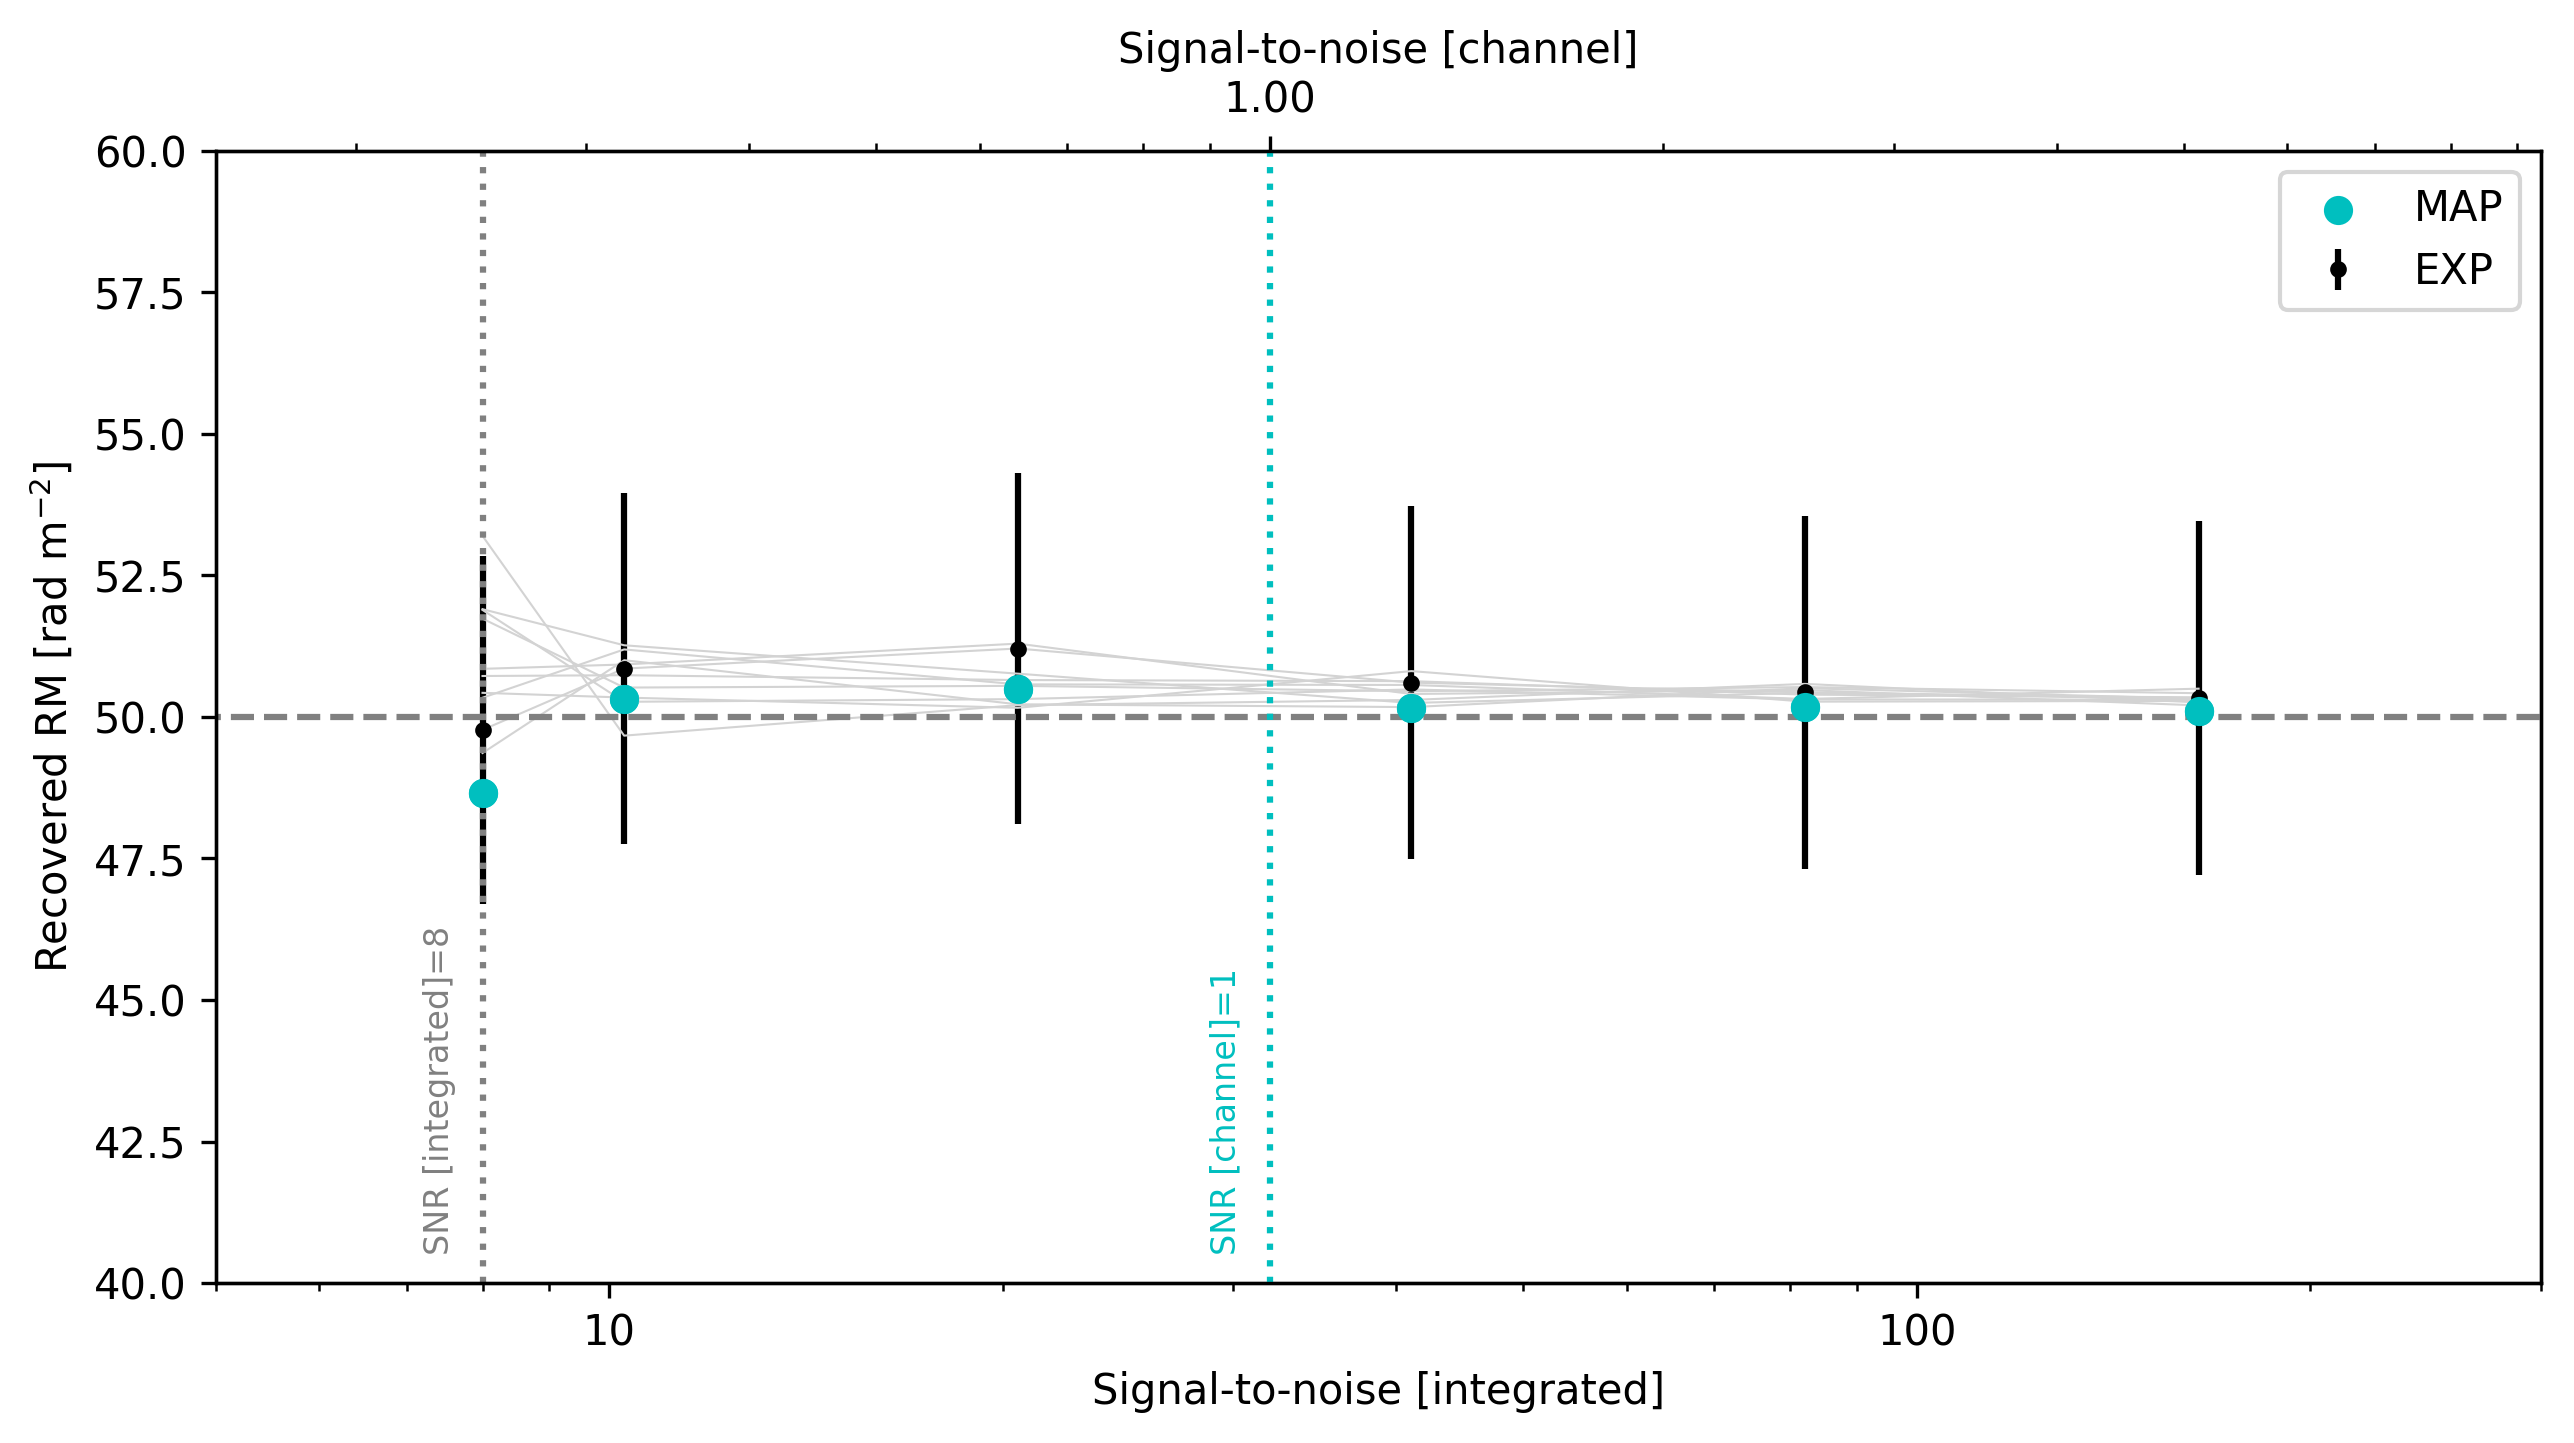

In [7]:
snr_ch = p0/np.array(noise)
snr = np.sqrt(len(stokesQ))*snr_ch

pdata = []
ax = pl.subplot(111)

nreal = 10
for n in tqdm_notebook(range(nreal)):
    mls,exs,asym_errors = runreal(l2, stokesQ, stokesU,  noise)
    ax.plot(snr,exs,ls='-',lw=0.5,c='lightgrey')
    
# plot ML values from final realisation:
ax.scatter(snr,mls,marker='o',c='c',label="MAP")
# plot EXP values from final realisation:
ax.errorbar(snr,exs,yerr=asym_errors,fmt='.',color='black',label="EXP")

# true value:
ax.plot([0,300],[50.,50.],ls='--',c='grey')

# 8 sigma integrated flux:
ax.plot([8,8],[40.,60.],ls=':',c='grey')
ax.text(7.2, 40.5, 'SNR [integrated]=8', color='grey', fontsize=8, rotation=90, verticalalignment='bottom')

# plot axis with channel SNRs:
ax2 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax2.scatter(snr_ch,mls,marker='o',c='c')

# 1 sigma channel flux:
ax2.plot([1,1],[40.,60.],ls=':',c='c')
ax2.text(0.9, 40.5, 'SNR [channel]=1', color='c', fontsize=8, rotation=90, verticalalignment='bottom')

# plot labels:
ax.set_xlabel("Signal-to-noise [integrated]")
ax2.set_xlabel("Signal-to-noise [channel]")  # we already handled the x-label with ax1
ax.set_ylabel(r"Recovered RM [rad m$^{-2}$]")

# format axes:
ax.axis([5.,300.,40.,60.])
ax2.axis([5./np.sqrt(len(stokesQ)),300./np.sqrt(len(stokesQ)),40.,60.])
ax.semilogx()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax2.semilogx()
ax2.xaxis.set_major_formatter(ScalarFormatter())

# add legend:
ax.legend()

# display plot:
pl.show()